In [1]:
import sqlalchemy
from sqlalchemy.sql import text
import pandas as pd
import glob
import os
import pickle
import seaborn as sns
import datetime
from copy import deepcopy
import yaml
import numpy as np

import tensorflow as tf
import tflearn

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [3]:
with open('server_config.yaml', 'r') as f:
        server = yaml.load(f)

host = server['host']
database = server['database']
user = server['user']
password = server['password']

FileNotFoundError: [Errno 2] No such file or directory: 'server_config.yaml'

In [6]:
url = 'postgresql://{}:{}@{}/{}'
url = url.format(user, password, host, database)
conn = sqlalchemy.create_engine(url)

NameError: name 'user' is not defined

In [96]:
indice = pd.read_sql_query('SELECT * FROM indicadores.camdep_apoio_governo_bancada_voto_parlamentar_raw',
                                        conn)

votacao = pd.read_sql_query('SELECT * FROM desenv.cam_votacao_bancada_governo',
                                        conn)

In [97]:
analise = votacao.merge(indice, on='votacao_id')

In [98]:
analise.columns

Index(['index_x', 'ano', 'codproposicao_x', 'codsessao_x', 'datavotacao',
       'numero', 'orientacao', 'partido_bloco', 'sigla', 'tipo', 'votacao_id',
       'level_0', 'index_y', 'DEM', 'PCDOB', 'PDT', 'PEN', 'PHS', 'PMB',
       'PMDB', 'PMN', 'PP', 'PPS', 'PR', 'PRB', 'PROS', 'PRP', 'PRTB', 'PSB',
       'PSC', 'PSD', 'PSDB', 'PSDC', 'PSL', 'PSOL', 'PSTU', 'PT', 'PTB', 'PTC',
       'PTDOB', 'PTN', 'PV', 'REDE', 'S.PART.', 'SD', 'Apoio Médio',
       'datavotacao_x', 'codsessao_y', 'datavotacao_y', 'codproposicao_y'],
      dtype='object')

In [99]:
del analise['codproposicao_x']
del analise['codproposicao_y']
del analise['datavotacao_y']
del analise['codsessao_y']
del analise['datavotacao_x']
del analise['index_x']
del analise['votacao_id']
del analise['partido_bloco']
del analise['level_0']
del analise['index_y']
del analise['codsessao_x']

In [100]:
del analise['numero']

In [101]:
analise = analise.fillna(0)

In [102]:
analise.columns

Index(['ano', 'datavotacao', 'orientacao', 'sigla', 'tipo', 'DEM', 'PCDOB',
       'PDT', 'PEN', 'PHS', 'PMB', 'PMDB', 'PMN', 'PP', 'PPS', 'PR', 'PRB',
       'PROS', 'PRP', 'PRTB', 'PSB', 'PSC', 'PSD', 'PSDB', 'PSDC', 'PSL',
       'PSOL', 'PSTU', 'PT', 'PTB', 'PTC', 'PTDOB', 'PTN', 'PV', 'REDE',
       'S.PART.', 'SD', 'Apoio Médio'],
      dtype='object')

In [103]:
analise['year'] = analise['datavotacao'].apply(lambda x: x.year)
analise['month'] = analise['datavotacao'].apply(lambda x: x.month)
analise['day'] = analise['datavotacao'].apply(lambda x: x.weekday())
analise['weekday'] = analise['datavotacao'].apply(lambda x: x.day)
analise['hour'] = analise['datavotacao'].apply(lambda x: x.hour)

In [104]:
analise.columns

Index(['ano', 'datavotacao', 'orientacao', 'sigla', 'tipo', 'DEM', 'PCDOB',
       'PDT', 'PEN', 'PHS', 'PMB', 'PMDB', 'PMN', 'PP', 'PPS', 'PR', 'PRB',
       'PROS', 'PRP', 'PRTB', 'PSB', 'PSC', 'PSD', 'PSDB', 'PSDC', 'PSL',
       'PSOL', 'PSTU', 'PT', 'PTB', 'PTC', 'PTDOB', 'PTN', 'PV', 'REDE',
       'S.PART.', 'SD', 'Apoio Médio', 'year', 'month', 'day', 'weekday',
       'hour'],
      dtype='object')

In [117]:
analise = pd.read_csv('apoio_governo_features.csv')

In [118]:
analise['aux'] = analise['weekday']
analise['weekday'] = analise['day']
analise['day'] = analise['aux']

del analise['aux']
del analise['datavotacao']
del analise['sigla']

analise.head()

,ano,orientacao,tipo,DEM,PCDOB,PDT,PEN,PHS,PMB,PMDB,...,PV,REDE,S.PART.,SD,Apoio Médio,year,month,day,weekday,hour
0,1997,Sim,PL,1.000000,1.0,0.952381,0.0,0.000000,0.0,0.942857,...,1.000000,0.0,0.0,0.0,0.969388,1998,11,25,2,12
1,1996,Sim,PEC,1.000000,1.0,1.000000,0.0,1.000000,0.0,0.984375,...,0.000000,0.0,1.0,0.0,0.997199,2001,9,25,1,18
2,2012,Não,MPV,0.000000,1.0,0.928571,0.0,1.000000,0.0,1.000000,...,1.000000,0.0,0.0,0.0,0.820847,2012,7,11,2,19
3,2007,Não,MPV,0.166667,1.0,1.000000,0.0,1.000000,0.0,0.967213,...,0.909091,0.0,0.0,0.0,0.750000,2007,11,13,1,11
4,2016,Sim,PL,1.000000,0.0,0.090909,0.5,0.833333,0.0,0.945455,...,1.000000,0.0,0.0,1.0,0.741117,2016,10,5,2,20


In [119]:
dummy_fields = ['ano', 'orientacao', 'tipo', 'year', 'month', 'day', 'weekday', 'hour']
for each in dummy_fields:
    dummies = pd.get_dummies(analise[each], prefix=each, drop_first=False)
    analise = pd.concat([analise, dummies], axis=1)

fields_to_drop = ['ano', 'orientacao', 'tipo', 'year', 'month', 'day', 'weekday', 'hour']

analise = analise.drop(fields_to_drop, axis=1)
analise.head()

,DEM,PCDOB,PDT,PEN,PHS,PMB,PMDB,PMN,PP,PPS,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1.000000,1.0,0.952381,0.0,0.000000,0.0,0.942857,0.0,0.965517,0.2,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,1.0,1.000000,0.0,1.000000,0.0,0.984375,0.0,1.000000,1.0,...,0,0,0,0,1,0,0,0,0,0
2,0.000000,1.0,0.928571,0.0,1.000000,0.0,1.000000,1.0,0.952381,0.0,...,0,0,0,0,0,1,0,0,0,0
3,0.166667,1.0,1.000000,0.0,1.000000,0.0,0.967213,1.0,0.964286,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,0.0,0.090909,0.5,0.833333,0.0,0.945455,0.0,0.878788,1.0,...,0,0,0,0,0,0,1,0,0,0


In [120]:
analise_train = analise[0:1600]
analise_test = analise[1601:]

del analise

analise_train_pt = analise_train['PT'].values
analise_train_pt = analise_train_pt[:, np.newaxis]
analise_train_features = analise_train.drop('PT', axis = 1).values


analise_test_pt = analise_test['PT'].values
analise_test_features = analise_test.drop('PT', axis = 1).values

del analise_train
del analise_test

In [161]:
# Define the neural network
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    # Inputs
    net = tflearn.input_data([None, analise_train_features.shape[1]])

    # Hidden layer(s)
    net = tflearn.fully_connected(net, 16, activation='ReLU')
#    net = tflearn.fully_connected(net, 16, activation='ReLU')
    net = tflearn.dropout(net, 0.80)
    
    # Output layer and training model
    net = tflearn.fully_connected(net, 1, activation='sigmoid')
    net = tflearn.regression(net, optimizer='sgd', learning_rate=0.1, loss="mean_square")
    
    model = tflearn.DNN(net)
    return model

model = build_model()

In [162]:
model.fit(analise_train_features, analise_train_pt, validation_set=0.1, show_metric=True, batch_size=80, n_epoch=30)

Training Step: 539  | total loss: 0.03749 | time: 0.050s
| SGD | epoch: 030 | loss: 0.03749 - binary_acc: 0.5182 -- iter: 1360/1440
Training Step: 540  | total loss: 0.03703 | time: 1.058s
| SGD | epoch: 030 | loss: 0.03703 - binary_acc: 0.5139 | val_loss: 0.03263 - val_acc: 0.5563 -- iter: 1440/1440
--


In [163]:
from sklearn.metrics import log_loss
# Compare the labels that our model predicts with the actual labels

# Find the indices of the most confident prediction for each item. That tells us the predicted digit for that sample.
predictions = np.array(model.predict(analise_test_features))

# Calculate the accuracy, which is the percentage of times the predicated labels matched the actual labels
print("Mean Square:", np.mean((analise_test_pt - predictions)**2))

Mean Square: 0.23963821807


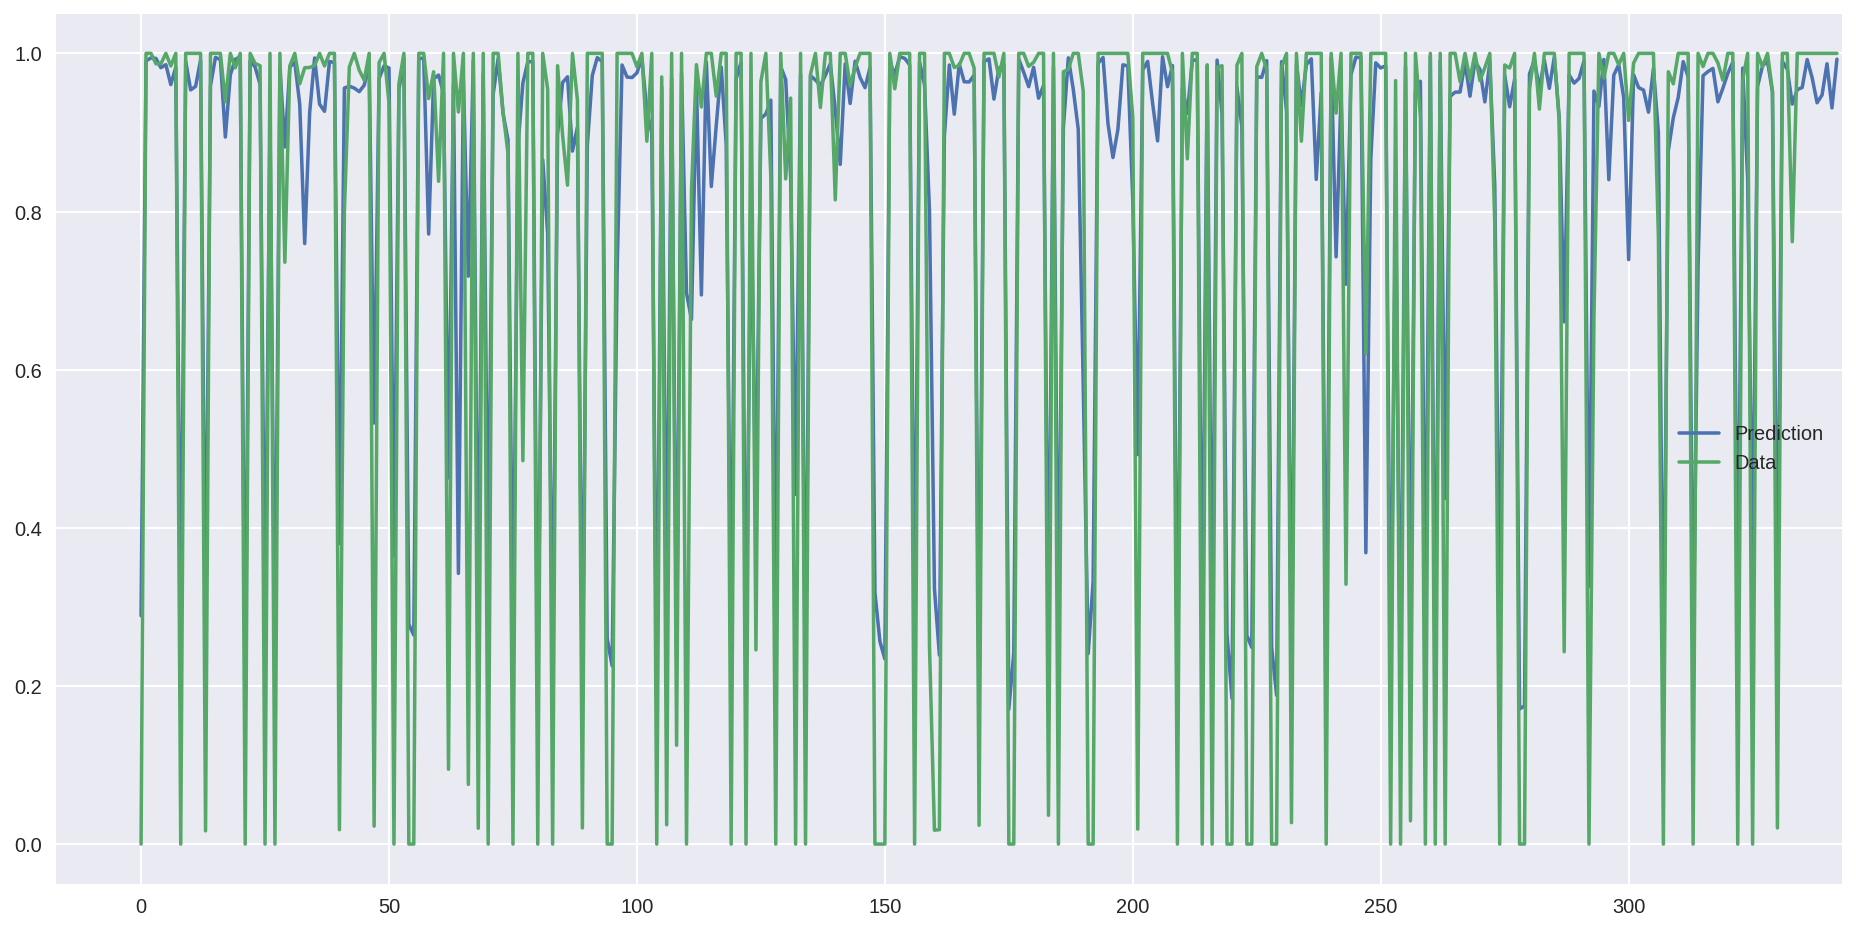

In [164]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(predictions, label='Prediction')
ax.plot(analise_test_pt, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()


In [143]:
analise_test_pt

array([ 0.        ,  1.        ,  1.        ,  0.98684211,  0.98684211,
        1.        ,  0.98412698,  1.        ,  0.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.01666667,  1.        ,
        1.        ,  1.        ,  0.93877551,  1.        ,  0.98181818,
        1.        ,  0.        ,  1.        ,  0.98717949,  0.984375  ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.73584906,
        0.98412698,  1.        ,  0.96153846,  0.98181818,  0.98214286,
        0.98484848,  1.        ,  0.98412698,  1.        ,  1.        ,
        0.01818182,  0.8       ,  0.98275862,  1.        ,  0.9787234 ,
        0.96610169,  1.        ,  0.02272727,  0.98837209,  1.        ,
        0.9375    ,  0.        ,  0.96153846,  1.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.94285714,  0.97674419,
        0.83823529,  1.        ,  0.09459459,  1.        ,  0.92592593,
        1.        ,  0.0754717 ,  1.        ,  0.02      ,  1.  